# Install required enviroment

In [1]:
!pip install torch==1.5.0
!pip3 install transformers==3.5.0

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import regex as re
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf

In [ ]:
def clear_emoji(text):
    regrex_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)

    return regrex_pattern.sub(r'', text)

def dataset_wo_emoji(dfs):
  for i in range(dfs.shape[0]):
    for j in range(dfs.shape[1]):
      splited = (str(dfs.iloc[i,j]).split())
      for u in range(len(splited)):
        splited[u] = clear_emoji(splited[u])
      res_str = ' '.join(splited)
      dfs.iloc[i, j] = res_str
  return dfs

### A little about data

In the generated data:

69 headings (my part of work) and 90 full messages (my guys' work results)

In the real data:

75 headings and 76 full messages

The distribution of the target variable  is balanced, so let's custome our data and work with BERT

### Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
results = pd.ExcelFile("drive/MyDrive/course_work/results.xlsx")
neuro_mess = pd.read_excel(results, 'Сгенеренное')[["Текст от нейросети"]]
real_mess = pd.read_excel(results, 'Исходный')[["Сообщение от HR"]]
real_head = pd.read_csv("drive/MyDrive/course_work/Headings.csv")[["Только заголовок"]]

neuro_mess = neuro_mess.rename(columns={"Текст от нейросети": "mess"}).dropna()
real_mess = real_mess.rename(columns={"Сообщение от HR": "mess"})
real_head = real_head.rename(columns={"Только заголовок": "mess"})

neuro_mess["label"] = 0
real_mess["label"] = 1

### 0 -- a generated message

### 1 -- a real message

In [ ]:
data = pd.concat([neuro_mess, real_mess, real_head])

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
data = dataset_wo_emoji(data)
data["label"] = data["label"].apply(int)

### Preparing data for a model training

Split data on two parts to be able to check our model's working capacity in the future

In [ ]:
train_data, valid_data = train_test_split(data, test_size=0.2)

In [ ]:
print("Train data samples:", train_data.shape[0])
print("Valid data samples:", valid_data.shape[0])

Train data samples: 248
Valid data samples: 62


In [ ]:
train_values = train_data["mess"].values
train_labels = train_data["label"].values

valid_values = valid_data["mess"].values
valid_labels = valid_data["label"].values

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Let's encode our data 

In [ ]:
train_encodings = tokenizer(list(train_values),
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(list(valid_values),
                            truncation=True,
                            padding=True)

### Let's make datasets in the required format (I spied this moment on the HuggingFace :) )

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    valid_labels
))

# Fit BERT

### Load model

In [2]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

### The learning process itself

In [3]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
model.fit(train_dataset.shuffle(10).batch(8),
          epochs=3,
          batch_size=16,
          validation_data=val_dataset.shuffle(10).batch(8))

### Save pretrained by us model

In [ ]:
model.save_pretrained("drive/MyDrive/course_work/finetuned_BERT")

### Function for convenient prediction and accuracy calculating

In [ ]:
def model_predict(model, text):
  predict_input = tokenizer.encode(text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")
  tf_output = model.predict(predict_input)
  return tf.nn.sigmoid(tf_output).numpy().argmax()

In [ ]:
def get_acc(ground_truth, predicted, show=False):
  try:
    acc = (ground_truth==predicted).sum()/len(predicted)
    if show:
      print(f"Accuracy: {acc}")
    return acc
  except:
    print("Here is probably troubles with sizes")

Let's calculate accuracy on the full dataset for validation

In [ ]:
predict_valid = valid_data["mess"].apply(model_predict)
ground_truth = valid_data["label"]
get_acc(ground_truth, predict_valid)

Now do it only with the real HRs messages

In [ ]:
predict_valid = valid_data[valid_data["label"] == 1]["mess"].apply(model_predict)
ground_truth = valid_data[valid_data["label"] == 1]["label"]
get_acc(ground_truth, predict_valid)

Accuracy: 0.8857142857142857


0.8857142857142857

Now with the generated messages separately

In [ ]:
predict_valid = valid_data[valid_data["label"] == 0]["mess"].apply(model_predict)
ground_truth = valid_data[valid_data["label"] == 0]["label"]
get_acc(ground_truth, predict_valid)

Accuracy: 0.4074074074074074


0.4074074074074074

### A little interpretation:

Our pretrained model demonstrates much better accuracy with the real messages unlike with the generated messages

That probably means that our synthetic messages look like a real messages. Also, relatively high accuracy value with the real messages says, that pretrained model can distinguish origin texts not bad -- this sign is good for us, 'cause it proofs that a gap beetwen two accuracy values is conditioned not by troubles with classification algorithm, but by a high quality of generated samples

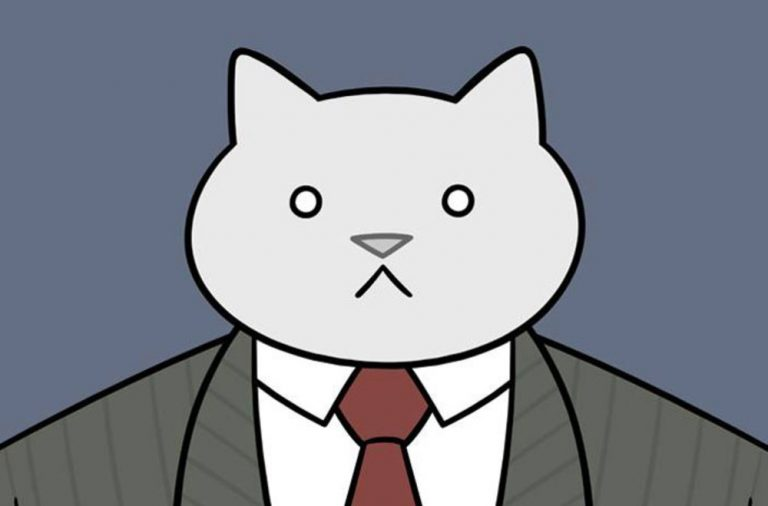

# A little revelation

The idea of train as strong neural network for classification as BERT to distinguish real texts from generated by another one cool NN messages is brilliant and inspiring (I do think so)

And, of course, it could be implemented better and more vividly)) 
And I didn't do that as exciting as I wondered about it

But in the end it doesn't even matter. So let's say that it was a cool, inspite of tiny experiment!